# Vanguard project

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Import data

In [2]:
demo_url = 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt'
experiment_url = 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt'
web_data1 = 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt'
web_data2 = 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt'

In [3]:
df_demo = pd.read_table(demo_url, sep = ',')
df_exp = pd.read_table(experiment_url, sep = ',')
df_web1 = pd.read_table(web_data1, sep = ',')
df_web2 = pd.read_table(web_data2, sep = ',')

In [2]:
drop_index = pd.read_table(r'../data/drop_union.csv', sep = ',')

## Data cleaning
### df_demo

In [6]:
df_demo.isnull().value_counts()

client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age  gendr  num_accts  bal    calls_6_mnth  logons_6_mnth
False      False           False             False     False  False      False  False         False            70594
           True            True              True      True   True       True   True          True                14
           False           False             True      False  False      False  False         False                1
Name: count, dtype: int64

In [7]:
# Identify null rows, IDs present but no actionable data
demo_drop = df_demo[df_demo['clnt_tenure_yr'].isnull() == True]

# Drop rows
df_demo = df_demo.drop(labels = list(demo_drop.index), axis = 0)

In [8]:
# 1 missing value remaining in client age - already cast as float64 so no need to recast
df_demo.isnull().value_counts()

client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age  gendr  num_accts  bal    calls_6_mnth  logons_6_mnth
False      False           False             False     False  False      False  False         False            70594
                                             True      False  False      False  False         False                1
Name: count, dtype: int64

In [9]:
def drop_null_rows(df, control_col : str):
    to_drop = df[df[control_col].isnull() == True].index
    new_df = df.drop(labels = list(to_drop), axis = 0)
    return new_df

In [10]:
df_demo = drop_null_rows(df_demo, 'clnt_tenure_yr')

### df_exp

In [10]:
df_exp.shape

(70609, 2)

In [11]:
# isnull() indicates that there are 20,500 values with no information on which variation they experienced.
# This renders the entries useless with regard to the A/B testing
# Drop values

In [12]:
df_exp = drop_null_rows(df_exp, 'Variation')

In [13]:
# No null values present
df_exp.isnull().sum()

client_id    0
Variation    0
dtype: int64

### webdata1 & 2

In [31]:
df_web1.shape

(343141, 5)

In [15]:
df_web2.shape

(412264, 5)

In [16]:
# Ensure columns are identical
df_web1.columns == df_web2.columns

array([ True,  True,  True,  True,  True])

In [4]:
# Concatenate tables
df_web = pd.concat([df_web1,df_web2])

In [33]:
# Confirm concat success
df_web.shape

(755405, 5)

In [34]:
df_web['client_id'].nunique()

120157

In [3]:
drop_list = list(drop_index['drop_column'])

In [9]:
df_dropped = df_web.loc[list(drop_list)]

In [11]:
# Merge df_dropped with exp to return control/test variants
dropped_join = df_dropped.merge(df_exp[['client_id', 'Variation']], on='client_id', how='left', suffixes=('', '_exp'), validate='many_to_one')

In [5]:
# Merge df_web with df_exp for total variation counts
web_join = df_web.merge(df_exp[['client_id', 'Variation']], on='client_id', how='left', suffixes=('', '_exp'), validate='many_to_one')

## Analysis

### Completion rate

In [22]:
# Get all confirm steps
web_confirms = web_join[web_join['process_step'] == 'confirm']

# Get number of unique client_id
control_id_len = web_join['client_id'][web_join['Variation'] == 'Control'].nunique()
test_id_len = web_join['client_id'][web_join['Variation'] == 'Test'].nunique()

# Split by variation
confirm_ids_control = web_confirms['client_id'][web_confirms['Variation'] == 'Control']
confirm_ids_test = web_confirms['client_id'][web_confirms['Variation'] == 'Test']

# Get unique client_ids
proportion_control = confirm_ids_control.nunique() / control_id_len
proportion_test = confirm_ids_test.nunique() / test_id_len

print("Proportion of Control that reaches the 'Confirm' step: ", proportion_control)
print("Proportion of Test that reaches the 'Confirm' step: ", proportion_test)


Proportion of Control that reaches the 'Confirm' step:  0.6558728539860615
Proportion of Test that reaches the 'Confirm' step:  0.6929323642835954


In [23]:
completion_dict = {'Control' : proportion_control, 'Test' : proportion_test}

In [26]:
completion_df = pd.DataFrame.from_dict(completion_dict, orient = 'index')

In [28]:
completion_df.to_csv('completion_df')

### Age distribution

In [51]:
demo_join = df_demo.merge(df_exp[['client_id', 'Variation']], on='client_id', how='left', suffixes=('', '_exp'), validate='many_to_one')

In [ ]:
# Generate pct values of distribution segmented by variation
list(demo_join['gendr'][demo_join['Variation']=='Test'].value_counts() / len(demo_join['gendr'][demo_join['Variation']=='Test'])*100)

control_gender = list(demo_join['gendr'][demo_join['Variation']=='Control'].value_counts() / len(demo_join['gendr'][demo_join['Variation']=='Control'])*100)
control_gender.append(0)

In [ ]:
# Create dictionary with new values and load to df
gender_dict = {'Control' : control_gender, 
               'Test': list(demo_join['gendr'][demo_join['Variation']=='Test'].value_counts() / len(demo_join['gendr'][demo_join['Variation']=='Test'])*100)}

gender_dist = pd.DataFrame.from_dict(gender_dict)

### Repeated values

In [ ]:
# Calculate pct of repeated steps according to variation

(dropped_join['Variation']=='Control').sum()/len(web_join[web_join['Variation']=='Control'])*100

((dropped_join['Variation']=='Test') & (dropped_join['process_step']=='start')).sum()/len(web_join[web_join['Variation']=='Test'])*100

In [40]:
repeat_dict = { 'Control': {
    'Start': (((dropped_join['Variation']=='Control') & (dropped_join['process_step']=='start')).sum()/len(web_join[web_join['Variation']=='Control'])*100),
    'Step 1': (((dropped_join['Variation']=='Control') & (dropped_join['process_step']=='step_1')).sum()/len(web_join[web_join['Variation']=='Control'])*100),
    'Step 2': (((dropped_join['Variation']=='Control') & (dropped_join['process_step']=='step_2')).sum()/len(web_join[web_join['Variation']=='Control'])*100),
    'Step 3': (((dropped_join['Variation']=='Control') & (dropped_join['process_step']=='step_3')).sum()/len(web_join[web_join['Variation']=='Control'])*100),
    'Confirm': (((dropped_join['Variation']=='Control') & (dropped_join['process_step']=='confirm')).sum()/len(web_join[web_join['Variation']=='Control'])*100)},
    'Test': {
    'Start': (((dropped_join['Variation']=='Test') & (dropped_join['process_step']=='start')).sum()/len(web_join[web_join['Variation']=='Test'])*100),
    'Step 1': (((dropped_join['Variation']=='Test') & (dropped_join['process_step']=='step_1')).sum()/len(web_join[web_join['Variation']=='Test'])*100),
    'Step 2': (((dropped_join['Variation']=='Test') & (dropped_join['process_step']=='step_2')).sum()/len(web_join[web_join['Variation']=='Test'])*100),
    'Step 3': (((dropped_join['Variation']=='Test') & (dropped_join['process_step']=='step_3')).sum()/len(web_join[web_join['Variation']=='Test'])*100),
    'Confirm': (((dropped_join['Variation']=='Test') & (dropped_join['process_step']=='confirm')).sum()/len(web_join[web_join['Variation']=='Test'])*100)}}

In [42]:
repeat_df = pd.DataFrame.from_dict(repeat_dict)

### Client profile

In [13]:
client_group = df_demo.groupby('client_id')

In [28]:
unique_client = df_demo['client_id'].unique()
df_demo[df_demo['client_id'] == unique_client]['gendr'].value_counts()

gendr
U    24122
M    23724
F    22746
X        3
Name: count, dtype: int64

In [18]:
gender_df = client_group['gendr'].sum()


In [48]:
# add column for gender assigning numerical values for each categorical value.

# get index list for each unique value
u_index = list(df_demo[df_demo['gendr'] == 'U'].index) # assign 0
m_index = list(df_demo[df_demo['gendr'] == 'M'].index) # assign 1
f_index = list(df_demo[df_demo['gendr'] == 'F'].index) # assign 2
x_index = list(df_demo[df_demo['gendr'] == 'X'].index) # assign 3

# create dictionary with indices
gendr_dict = {0:u_index, 1:m_index, 2:f_index, 3:x_index}

# create new column with default value
df_demo['gendr_v'] = -1

# iterate over dictionary and fill new column with keys
for key, values in gendr_dict.items():
    for i in values:
        df_demo.loc[i, 'gendr_v'] = key

# check for success
df_demo['gendr_v'].value_counts()


gendr_v
 0    24122
 1    23724
 2    22746
-1       14
 3        3
Name: count, dtype: int64

In [23]:
# Focusing on data from df_demo

# df_demo['clnt_tenure_yr'].describe()
# df_demo['clnt_age'].describe()
# df_demo['gendr'].value_counts()/len(df_demo['gendr'])*100
# df_demo['num_accts'].describe()
df_demo['bal'].describe()
# df_demo['calls_6_mnth'].describe()
# df_demo['logons_6_mnth'].describe()

count    7.059500e+04
mean     1.474452e+05
std      3.015087e+05
min      1.378942e+04
25%      3.734683e+04
50%      6.333290e+04
75%      1.375449e+05
max      1.632004e+07
Name: bal, dtype: float64

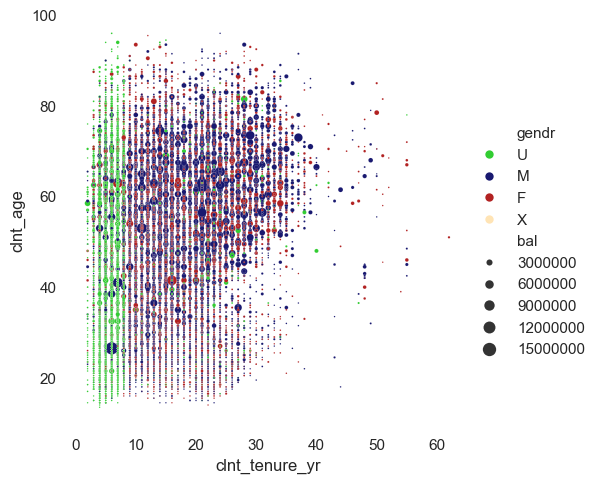

In [112]:
# Set style
sns.set_theme(style = "white", palette = ['limegreen','midnightblue','firebrick','moccasin'], font = "sans serif")

g = sns.relplot(
    data=df_demo,
    x="clnt_tenure_yr", y="clnt_age", size="bal", hue ="gendr", sizes=(1, 100),
)
# g.set(xscale="log", yscale="log")
# g.ax.xaxis.grid(True, "minor", linewidth=.25)
# g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.savefig('client_scatter.png', dpi = 300)

In [49]:
# filter out balances under 500k for visualisation purposes

bal_500_plus = df_demo[df_demo['bal']>500000]
bal_500_sub = df_demo[df_demo['bal']<500000]

# Filter by gender
data0 = bal_500_plus[bal_500_plus['gendr_v'] == 0]
data1 = bal_500_plus[bal_500_plus['gendr_v'] == 1]
data2 = bal_500_plus[bal_500_plus['gendr_v'] == 2]
data3 = bal_500_plus[bal_500_plus['gendr_v'] == 3]

# Filter by gender
gendr_0 = df_demo[df_demo['gendr_v'] == 0]
gendr_1 = df_demo[df_demo['gendr_v'] == 1]
gendr_2 = df_demo[df_demo['gendr_v'] == 2]
gendr_3 = df_demo[df_demo['gendr_v'] == 3]


### Where client tenure exceeds client age...

In [133]:
tenure_over_age = df_demo[df_demo['clnt_age']<df_demo['clnt_tenure_yr']]

Where client tenure exceeds client age, the average age of said client is 22.33 with a std of 5.55.

<Axes: ylabel='clnt_age'>

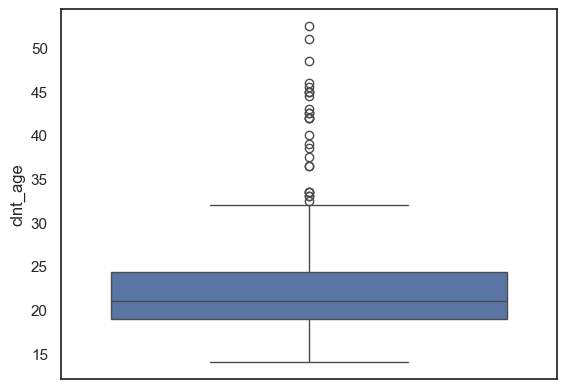

In [132]:
sns.boxplot(tenure_over_age)

### Explore average process step rates in web_data


In [29]:
confirm_df = df_web[df_web['process_step']=="confirm"]

In [32]:
# Drop duplicate rows
df_web_dup = df_web.drop_duplicates(keep = 'first')

In [ ]:
# Create a shifted DataFrame for comparison
df_shifted = df_web_dup.shift(1)

# Create a mask where 'process_step' and 'client_id' are the same in consecutive rows
mask_start = ((df_web_dup['process_step'] == df_shifted['process_step']) & 
        (df_web_dup['client_id'] == df_shifted['client_id']) & 
        (df_web_dup['process_step'] == 'start'))

# Get the indices to drop
start_drop = df_web_dup[mask_start].index

In [39]:
# Try with sample df
sample_index = i_sample[i_sample['process_step'] == 'start'].index
sample_list = []

for value in sample_index:
    try:
        if (i_sample.loc[value]['process_step'] == i_sample.loc[value-1]['process_step'] and
            i_sample.loc[value]['client_id'] == i_sample.loc[value-1]['client_id']):
            sample_list.append(value)
    finally:
        continue

In [40]:
i_sample.drop(index=sample_list)

,client_id,visitor_id,visit_id,process_step,date_time
333866,2128341,585028710_71643026491,206225469_90859667128_113497,start,2017-04-02 10:50:08
333893,2128341,923252049_38877790223,748958041_38511308408_739982,step_2,2017-03-29 13:50:33
333894,2128341,923252049_38877790223,748958041_38511308408_739982,step_1,2017-03-29 13:50:27
333895,2128341,923252049_38877790223,748958041_38511308408_739982,start,2017-03-29 13:50:14
333896,2128341,923252049_38877790223,748958041_38511308408_739982,step_3,2017-03-29 13:39:59
333897,2128341,923252049_38877790223,748958041_38511308408_739982,step_2,2017-03-29 13:37:23
333898,2128341,923252049_38877790223,748958041_38511308408_739982,step_1,2017-03-29 13:37:06
333899,2128341,923252049_38877790223,748958041_38511308408_739982,start,2017-03-29 13:36:40
333908,2128341,923252049_38877790223,300576108_9655535007_130343,step_1,2017-04-06 09:18:44
333909,2128341,923252049_38877790223,300576108_9655535007_130343,start,2017-04-06 09:17:18


In [90]:
# Create a shifted DataFrame for comparison
df_shifted = df_web_dup.shift(1)

# Create a mask where 'process_step' and 'client_id' are the same in consecutive rows
mask_start = ((df_web_dup['process_step'] == df_shifted['process_step']) & 
        (df_web_dup['client_id'] == df_shifted['client_id']) & 
        (df_web_dup['process_step'] == 'start'))

# Get the indices to drop
start_drop = df_web_dup[mask_start].index

In [82]:
# Create a shifted DataFrame for comparison
df_shifted = df_web_dup.shift(1)

# Create a mask where 'process_step' and 'client_id' are the same in consecutive rows
mask_s1 = ((df_web_dup['process_step'] == df_shifted['process_step']) & 
        (df_web_dup['client_id'] == df_shifted['client_id']) & 
        (df_web_dup['process_step'] == 'step_1'))

# Get the indices to drop
step_1_drop = df_web_dup[mask_s1].index

In [85]:
# Create a mask where 'process_step' and 'client_id' are the same in consecutive rows
mask_s2 = ((df_web_dup['process_step'] == df_shifted['process_step']) & 
        (df_web_dup['client_id'] == df_shifted['client_id']) & 
        (df_web_dup['process_step'] == 'step_2'))

# Get the indices to drop
step_2_drop = df_web_dup[mask_s2].index

In [86]:
# Create a mask where 'process_step' and 'client_id' are the same in consecutive rows
mask_s3 = ((df_web_dup['process_step'] == df_shifted['process_step']) & 
        (df_web_dup['client_id'] == df_shifted['client_id']) & 
        (df_web_dup['process_step'] == 'step_3'))

# Get the indices to drop
step_3_drop = df_web_dup[mask_s3].index

In [87]:
# Create a mask where 'process_step' and 'client_id' are the same in consecutive rows
mask_conf = ((df_web_dup['process_step'] == df_shifted['process_step']) & 
        (df_web_dup['client_id'] == df_shifted['client_id']) & 
        (df_web_dup['process_step'] == 'confirm'))

# Get the indices to drop
confirm_drop = df_web_dup[mask_conf].index

In [96]:
drop_union = start_drop.union(step_1_drop).union(step_2_drop).union(step_3_drop).union(confirm_drop)

In [97]:
df_cleaned = df_web_dup.drop(index=drop_union)

### Examining the relationship between gender, tenure and balance size

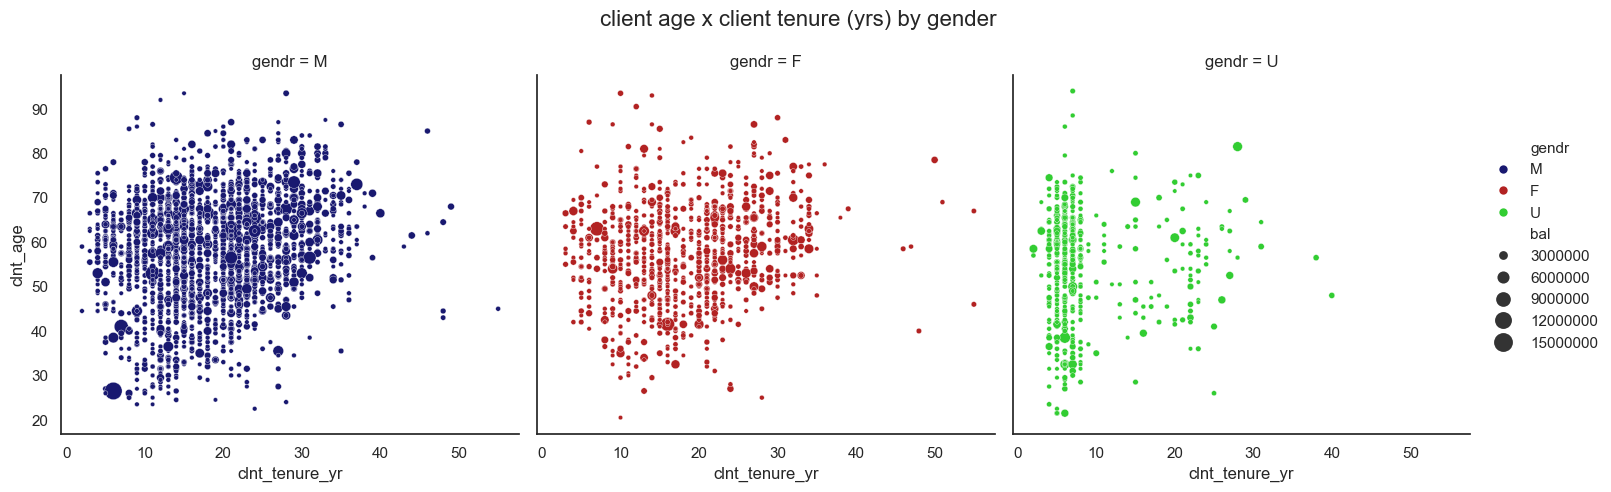

In [50]:
# Set style
sns.set_theme(style = "white", palette = ['midnightblue', 'firebrick', 'limegreen'], font = "sans serif")

# Create a relplot
g = sns.relplot(
    data=bal_500_plus,
    x="clnt_tenure_yr", y="clnt_age", size="bal", hue="gendr",
    col="gendr", col_wrap=3,
    height=5, sizes=(10, 200)
)

g.fig.suptitle('client age x client tenure (yrs) by gender', fontsize=16)
g.fig.subplots_adjust(top=0.85);

# Save plots 
plt.savefig('client_scatter_segmented.png', dpi = 300)

# Display the plots
plt.show()

### Examaining the relationship between age and gender (in 0-5mn of balance)

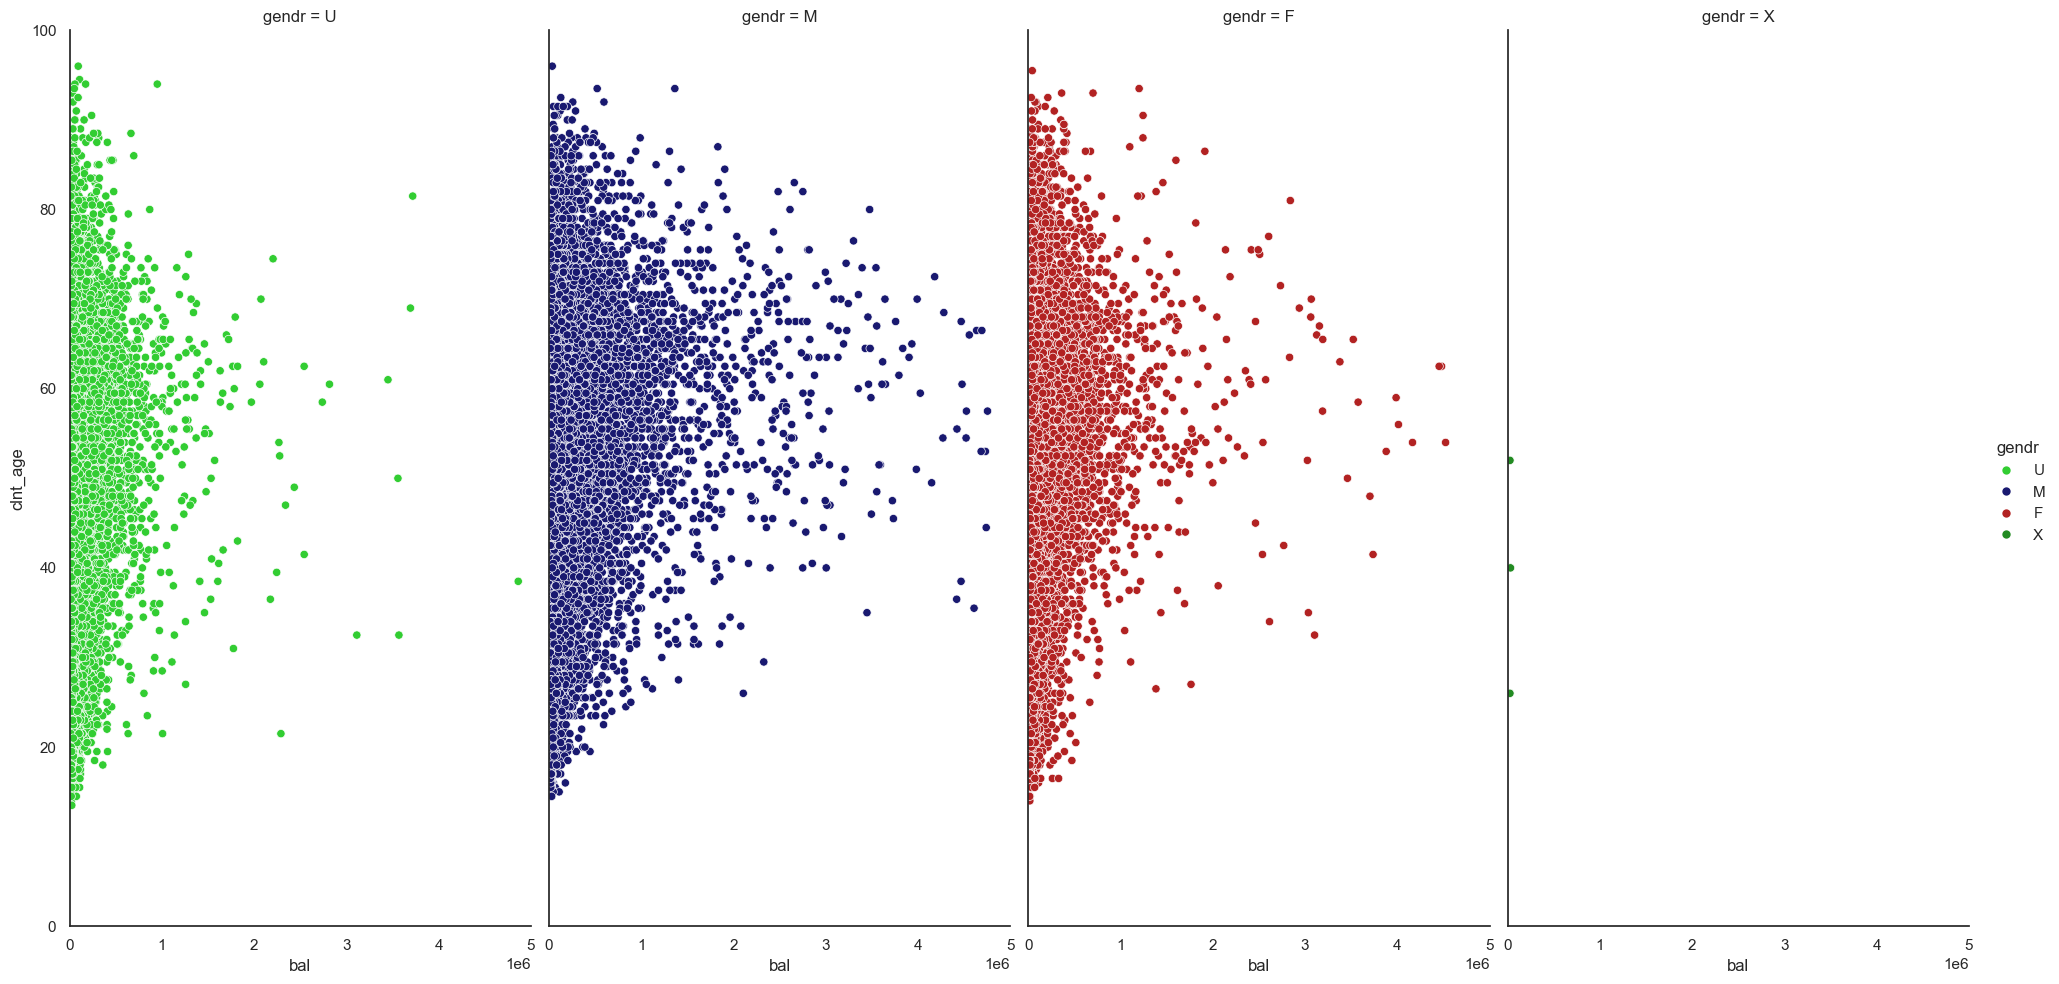

In [74]:
# Set style
palette = ['limegreen', 'midnightblue', 'firebrick','forestgreen']
sns.set_theme(style = "white", font = "sans serif")

# Create a relplot
sns.relplot(
    data=df_demo,
    x="bal", y="clnt_age", col = "gendr", col_wrap = 4, hue="gendr",
    palette=palette, height=10, aspect=0.5,
)
plt.ylim(0, 100)
plt.xlim(0, 5000000)

plt.savefig('client_age_segmented.png', dpi = 300)

plt.show()


## Insights

- Large proportion of "U" gender values are at the lower end of client tenure (~7 years and below), suggesting that it has become more common to select this option.
- Filtered data above 500k in balance removes majority of clients whose "clnt_age" exceeds "clnt_tenure_yr" (574 clients). It also reduces noise and enables the audience to focus on higher value customers. It is possible that these are family accounts/family members and retain parents or relatives length of tenure. 
- While M/F distribution relatively balanced in overall population, skewed towards men in 500k plus filtered version.

### Topline conclusions

The average client is:
- 46.4 yrs old
- has been a client for 12 years (starting at avg age 34)
- gender unknown
- has 2 accounts
- has a balance of USD 147,445.2
- has 3 calls every six months
- logs on 11 times a year



## Export cleaned data files

In [103]:
drop_union_df = pd.DataFrame(drop_union, columns = ['drop_column'])
drop_union_df.to_csv('drop_union', sep=',')

In [104]:
# Export web data with false steps removed

df_cleaned.to_csv('web_cleaned', sep=',')

In [106]:
df_demo.to_csv('demo_cleaned', sep = ',')

In [107]:
df_exp.to_csv('exp_cleaned', sep = ',')

In [134]:
tenure_over_age.to_csv('tenure_over_age', sep = ',')

In [44]:
repeat_df.to_csv('repeat_df.csv', sep= ',')

In [ ]:
gender_df.to_csv('gender_df', sep = ',')

In [ ]:
gender_dist.to_csv('gender_dist.csv', sep = ',')